# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [180]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [181]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [182]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    from collections import defaultdict

    # using defaultdict to simplify the process of adding data
    # (so that no need for explicit checks and initialisations for each key)
    X_train_scaled_dict = defaultdict(list)
    X_val_scaled_dict = defaultdict(list)
    y_train_dict = defaultdict(list)
    y_val_dict = defaultdict(list)

    # 5-fold cross-validation
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)

    # Loop through each batch size
    for bs in parameters:
        # For each batch size, iterate through the different folds generated by the K-Fold cross-validation
        # model is trained and validated on different subsets of the data
        # t_samples, v_samples = samples that are used for training and validation respectively in the current fold
        for t_samples, v_samples in kfold.split(X_train):
            # X_t = training data for the current fold
            X_t = X_train[t_samples]
            # y_t = corresponding target values (labels) of the training data in the current fold.
            y_t = y_train[t_samples]
            # X_v = validation data for the current fold
            X_v = X_train[v_samples]
            # y_v = corresponding target values (labels) of the validation data in the current fold.
            y_v = y_train[v_samples]

            # to scale the data
            scaler = preprocessing.StandardScaler()

            # Scale the training data and validation data
            X_t_scaled = scaler.fit_transform(X_t)
            X_v_scaled = scaler.transform(X_v)

            # append the scaled training and validation data to the respective dictionaries
            X_train_scaled_dict[bs].append(X_t_scaled)
            X_val_scaled_dict[bs].append(X_v_scaled)

            # Appending the labels for training and validation data to the respective dictionaries
            y_train_dict[bs].append(y_t)
            y_val_dict[bs].append(y_v)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

# Create preprocess function for datasets for kfold
def preprocess(df):
    df['label'] = preprocessing.LabelEncoder().fit_transform(df['label'])
    X_train = df.drop(['label', 'filename'], axis = 1)
    y_train = df['label'].to_numpy()

    return X_train, y_train

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

# apply preprocessing to dataset
X_train, y_train = preprocess(df)

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [183]:
# YOUR CODE HERE
from common_utils import EarlyStopper

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameter_name):
    # initialise dictonaries required for output
    cross_validation_accuracies = {}
    cross_validation_times = {}

    # Loop through batch sizes for hyperparameter tuning
    for bs in batch_sizes:
        # Lists to store accuracy and training time for each fold within a specific batch size
        current_batch_fold_validation_accuracies = []
        current_batch_fold_training_times = []

        # Perform 5-fold cross-validation
        for i in range(5):
            # initialisation of NN
            model = MLP(77, 128, 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # training and validation data for the current fold
            current_fold_X_train = X_train_scaled_dict[bs][i]
            current_fold_X_val = X_val_scaled_dict[bs][i]
            current_fold_y_train = y_train_dict[bs][i]
            current_fold_y_val = y_val_dict[bs][i]

            # Create CustomDataset objects for training and validation
            train_dataset = CustomDataset(current_fold_X_train, current_fold_y_train)
            val_dataset = CustomDataset(current_fold_X_val, current_fold_y_val)

            # Create DataLoader objects for training and validation
            train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

            # early stopping with patience of 3
            early_stopper = EarlyStopper(patience=3)
            loss_check = [] # store eval losses to check if need to do early stopping

            # Set the model to training mode
            model.train()
            for epoch in range(100): # follow number of epochs in A1
                epoch_start_time = time.time()

                # loop through training data
                for X_batch, y_batch in train_dataloader:
                    # Zero out gradients to prepare for a new batch
                    optimizer.zero_grad()
                    # Forward pass
                    y_pred = model(X_batch)
                    # do backpropagation to compute gradients of the loss with respect to model parameters
                    loss_fn(y_pred, y_batch).backward()
                    # Update model parameters (weights and biases) using the computed gradients
                    optimizer.step()

                epoch_end_time = time.time()
                current_batch_fold_training_times.append(epoch_end_time - epoch_start_time)

                # Evaluate the model on the validation data
                model.eval()
                with torch.no_grad():
                  fold_accuracy = []
                  fold_loss = []

                  for X_batch, y_batch in val_dataloader:
                      y_pred = model(X_batch)

                      # calculate accuracy
                      accuracy = (y_pred.round() == y_batch).float().mean()
                      fold_accuracy.append(float(accuracy))

                      loss = loss_fn(y_pred, y_batch)
                      fold_loss.append(loss.detach().numpy())

                  # Calculate and record the mean validation accuracy
                  current_batch_fold_validation_accuracies.append(sum(fold_accuracy) / len(fold_accuracy))
                  loss_check.append(sum(fold_loss)/len(fold_loss))

                if epoch % 10 == 0:
                    print(f"Batch Size: {bs}, Fold: {i}, Epoch: {epoch}, Fold Validation Loss: {loss_check[-1]}, Fold Validation Accuracy: {current_batch_fold_validation_accuracies[-1]*100:.2f}%")

                # Check for early stopping based on test loss (based on lecture notes)
                if early_stopper.early_stop(loss_check[-1]):
                    print(f"Early stopping implemented at epoch {epoch}.\n")
                    break

        # According to FAQ, mean cross-validation accuracies = cross validation accuracies
        # Store cross-validation accuracy on the LAST epoch for different batch sizes
        cross_validation_accuracies[bs] = current_batch_fold_validation_accuracies[-1]
        # Calculate time taken to train the network on the LAST epoch against different batch sizes
        cross_validation_times[bs] = current_batch_fold_training_times[-1]

    # Return the dictionaries containing hyperparameter tuning results
    return cross_validation_accuracies, cross_validation_times

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


Batch Size: 128, Fold: 0, Epoch: 0, Fold Validation Loss: 0.6727090007380435, Fold Validation Accuracy: 58.20%
Batch Size: 128, Fold: 0, Epoch: 10, Fold Validation Loss: 0.5867529354597393, Fold Validation Accuracy: 74.52%
Early stopping implemented at epoch 11.

Batch Size: 128, Fold: 1, Epoch: 0, Fold Validation Loss: 0.6705598799805892, Fold Validation Accuracy: 57.95%
Batch Size: 128, Fold: 1, Epoch: 10, Fold Validation Loss: 0.5553059201491507, Fold Validation Accuracy: 76.72%
Early stopping implemented at epoch 10.

Batch Size: 128, Fold: 2, Epoch: 0, Fold Validation Loss: 0.6795288669435602, Fold Validation Accuracy: 57.03%
Batch Size: 128, Fold: 2, Epoch: 10, Fold Validation Loss: 0.6157550247091996, Fold Validation Accuracy: 72.03%
Early stopping implemented at epoch 11.

Batch Size: 128, Fold: 3, Epoch: 0, Fold Validation Loss: 0.669766997036181, Fold Validation Accuracy: 58.48%
Batch Size: 128, Fold: 3, Epoch: 10, Fold Validation Loss: 0.5952710681839993, Fold Validation Acc

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

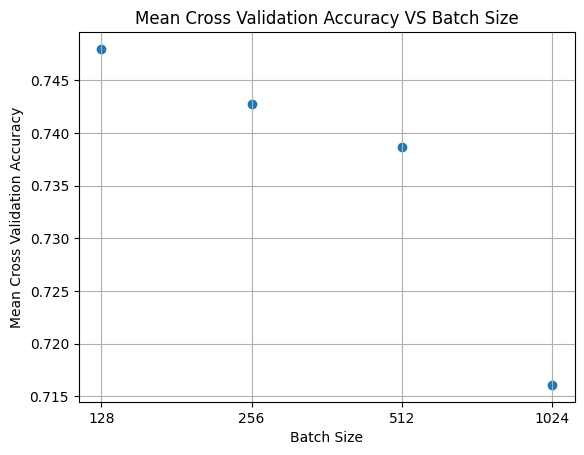

In [184]:
# YOUR CODE HERE
batch_sizes = list(cross_validation_accuracies.keys())
accuracies = list(cross_validation_accuracies.values())

plt.scatter(range(len(batch_sizes)), accuracies)
plt.xticks(range(len(batch_sizes)), batch_sizes)
plt.ylabel("Mean Cross Validation Accuracy")
plt.xlabel("Batch Size")
plt.title("Mean Cross Validation Accuracy VS Batch Size")
plt.grid(True)  # Add gridlines for better readability
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [185]:
df = pd.DataFrame({'Batch Size': batch_size,
                   'Last Epoch Time': last_epoch_time
                  } for batch_size, last_epoch_time in cross_validation_times.items())
df

,Batch Size,Last Epoch Time
0,128,0.252072
1,256,0.221444
2,512,0.159448
3,1024,0.242262


In [187]:
# YOUR CODE HERE
optimal_batch_size = 256

reason = "Batch size = 256 is the optimal choice due to its consistent performance in achieving one of the shortest training times and one of the highest mean cross-validation accuracy. \
On average, batch size = 256 outperformed the other batch sizes by completing training more quickly and achieving superior cross-validation accuracy. \
While there may be occasional variations across multiple test runs in terms of the values of 'Last Epoch Time' where batch size = 256 gives the slowest time taken, \
it remains a reliable choice that provides a good trade-off between training efficiency and model performance."

print(optimal_batch_size)
print(reason)

256
Batch size = 256 is the optimal choice due to its consistent performance in achieving one of the shortest training times and one of the highest mean cross-validation accuracy. On average, batch size = 256 outperformed the other batch sizes by completing training more quickly and achieving superior cross-validation accuracy. While there may be occasional variations across multiple test runs in terms of the values of 'Last Epoch Time' where batch size = 256 gives the slowest time taken, it remains a reliable choice that provides a good trade-off between training efficiency and model performance.
